In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

In [3]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24
S = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [7]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [8]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, S)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96337, 576)


In [9]:
prior_unknown_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),...,var3(t+22),var4(t+22),var5(t+22),var6(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,0.00,2.72,0.0,2.10,0.0,2.89,0.00,2.73
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,0.00,2.73,0.0,2.12,0.0,2.87,0.00,2.74
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.87,0.00,2.74,0.0,2.14,0.0,2.89,0.00,2.74
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.89,0.00,2.74,0.0,2.15,0.0,2.87,0.00,2.74
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.87,0.00,2.74,0.0,2.15,0.0,2.89,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54


#### Prior known covariates (9)

In [10]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, S)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96337, 864)


In [11]:
prior_known_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23),var7(t+23),var8(t+23),var9(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.28,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.73,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.85,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.49,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.21,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.79,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.31,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
12/30/20 21:00,1.31,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.86,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
12/30/20 22:00,0.86,0.0,0.0,2.58,0.0,0.0,2.57,0.0,0.000000,0.42,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


### N_out, N_in, K

#### all past covariates in past $w$ hours

In [12]:
# 15 covariates in total
cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

cov_supervised = series_to_supervised(cov, n_hours, S)
print("cov_supervised.shape:", cov_supervised.shape)

cov_supervised.shape: (96337, 1440)


In [13]:
past_cov_supervised = cov_supervised.iloc[:, :n_hours*cov.shape[1]]

In [14]:
past_cov_supervised  # 6 + 9 = 15 features

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.76,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.78,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.77,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.77,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.77,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.57,1.57,0.0,0.0,2.56,0.0,0.0,2.57,0.0,0.0
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.55,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.56,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0


#### all target water stages in past $w$ hours

In [15]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [16]:
past_ws_supervised  # 4

,past_ws_supervised_var1(t-72),past_ws_supervised_var2(t-72),past_ws_supervised_var3(t-72),past_ws_supervised_var4(t-72),past_ws_supervised_var1(t-71),past_ws_supervised_var2(t-71),past_ws_supervised_var3(t-71),past_ws_supervised_var4(t-71),past_ws_supervised_var1(t-70),past_ws_supervised_var2(t-70),...,past_ws_supervised_var3(t-3),past_ws_supervised_var4(t-3),past_ws_supervised_var1(t-2),past_ws_supervised_var2(t-2),past_ws_supervised_var3(t-2),past_ws_supervised_var4(t-2),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.38,1.34,1.79,1.92,1.94,1.91,2.11,2.29,2.27,2.21
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.94,1.91,2.11,2.29,2.27,2.21,2.07,2.27,2.26,2.22
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.27,2.21,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.60,0.54,1.14,1.18,1.17,1.25,1.62,1.65,1.70,1.67
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,1.17,1.25,1.62,1.65,1.70,1.67,1.93,1.95,2.00,2.00
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.70,1.67,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25


#### merge all data (ws, covariates) in past $w$ hours

In [17]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*cov.shape[1]:(i+1)*cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [18]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :], 
                                    past_ws_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :]], 
                                   axis=1)

past_cov_ws_supervised = past_cov_ws_supervised[columns]

In [19]:
past_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.11,2.29,2.27,2.21
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.07,2.27,2.26,2.22
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,1.57,1.80,1.80,1.72
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.81,1.04,1.03,0.96
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.56,0.0,0.0,2.57,0.0,0.0,1.62,1.65,1.70,1.67
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,1.93,1.95,2.00,2.00
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.57,0.0,0.0,2.57,0.0,0.0,2.19,2.21,2.25,2.25
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,2.11,2.12,2.22,2.19


#### shift prior known covariates in future  $S$ steps to the past

In [20]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, S*prior_known.shape[1]:]
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var1(t-47),...,shift_prior_known_supervised_var9(t+22),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.60,0.0,0.0,0.00,0.0,0.0,2.61,0.0,0.0,-0.07,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.68,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.68,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-1.02,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-1.02,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.97,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.97,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.50,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.0,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### merge all past data and shifted prior know future covariate

In [21]:
columns1 = []
for i in range(n_hours):
    columns1 = columns1 + past_cov_ws_supervised.columns[i*data.shape[1]:(i+1)*data.shape[1]].tolist()
    columns1 = columns1 + shift_prior_known_supervised.columns[i*prior_known.shape[1]:(i+1)*prior_known.shape[1]].tolist()
# columns

In [23]:
shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :], 
                                                 shift_prior_known_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :]],
                                                axis=1)

shift_prior_known_cov_ws_supervised = shift_prior_known_cov_ws_supervised[columns1]

In [24]:
# shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
#                                                      axis=1)

In [25]:
shift_prior_known_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,past_ws_supervised_var4(t-1),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.21,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.22,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.72,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.96,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.42,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,1.67,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.00,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.25,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.19,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### target water stage in future $k$ time steps

In [26]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25,2.11,2.12,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,2.19,2.21,2.25,2.25,2.11,2.12,2.22,2.19,1.65,1.69,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,2.11,2.12,2.22,2.19,1.65,1.69,1.76,1.72,1.24,1.24,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,1.65,1.69,1.76,1.72,1.24,1.24,1.37,1.32,0.76,0.73,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [27]:
all_data = concat([shift_prior_known_cov_ws_supervised, 
                   future_ws_supervised.iloc[:shift_prior_known_cov_ws_supervised.shape[0], :]], 
                  axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 2112)


In [28]:
all_data

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [29]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77069


In [30]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

2016

### Normalization

In [31]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77069, 2016) (77069, 96) (19268, 2016) (19268, 96)


In [32]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77069, 72, 28) (77069, 96) (19268, 72, 28) (19268, 96)


### Model

In [35]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

# 4 cnn without skip connection
x1 = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)
x1 = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1)
x1 = layers.Conv1D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1)
x1 = layers.Conv1D(filters=32, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1)


# 4 rnn without skip connection
x2 = layers.SimpleRNN(128, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)
x2 = layers.SimpleRNN(64, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2)
x2 = layers.SimpleRNN(32, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2)
x2 = layers.SimpleRNN(16, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2)


merge = concatenate([x1, x2])
merge = layers.Flatten()(merge)
# x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(merge)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(64, activation='relu')(x)
x = Dense(train_y.shape[1])(merge)

ws_pararcnn = Model(model_input, x)
ws_pararcnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 28)]     0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 72, 256)      14592       input_2[0][0]                    
__________________________________________________________________________________________________
simple_rnn_4 (SimpleRNN)        (None, 72, 128)      20096       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 72, 128)      65664       conv1d_4[0][0]                   
____________________________________________________________________________________________

Epoch 1/8000

Epoch 00001: val_mae improved from inf to 0.04508, saving model to saved_model/ws_pararcnn_sc4_4layer_24h.h5
151/151 - 90s - loss: 0.0757 - mae: 0.0535 - val_loss: 0.0528 - val_mae: 0.0451
Epoch 2/8000

Epoch 00002: val_mae improved from 0.04508 to 0.03602, saving model to saved_model/ws_pararcnn_sc4_4layer_24h.h5
151/151 - 23s - loss: 0.0405 - mae: 0.0234 - val_loss: 0.0339 - val_mae: 0.0360
Epoch 3/8000

Epoch 00003: val_mae improved from 0.03602 to 0.03158, saving model to saved_model/ws_pararcnn_sc4_4layer_24h.h5
151/151 - 22s - loss: 0.0277 - mae: 0.0162 - val_loss: 0.0247 - val_mae: 0.0316
Epoch 4/8000

Epoch 00004: val_mae improved from 0.03158 to 0.03017, saving model to saved_model/ws_pararcnn_sc4_4layer_24h.h5
151/151 - 21s - loss: 0.0207 - mae: 0.0135 - val_loss: 0.0192 - val_mae: 0.0302
Epoch 5/8000

Epoch 00005: val_mae improved from 0.03017 to 0.02915, saving model to saved_model/ws_pararcnn_sc4_4layer_24h.h5
151/151 - 21s - loss: 0.0163 - mae: 0.0126 - val_

Epoch 50/8000

Epoch 00050: val_mae did not improve from 0.02647
151/151 - 20s - loss: 5.2890e-04 - mae: 0.0098 - val_loss: 0.0014 - val_mae: 0.0269
Epoch 51/8000

Epoch 00051: val_mae did not improve from 0.02647
151/151 - 21s - loss: 5.2498e-04 - mae: 0.0098 - val_loss: 0.0014 - val_mae: 0.0272
Epoch 52/8000

Epoch 00052: val_mae improved from 0.02647 to 0.02633, saving model to saved_model/ws_pararcnn_sc4_4layer_24h.h5
151/151 - 21s - loss: 5.2010e-04 - mae: 0.0098 - val_loss: 0.0013 - val_mae: 0.0263
Epoch 53/8000

Epoch 00053: val_mae did not improve from 0.02633
151/151 - 21s - loss: 5.1715e-04 - mae: 0.0098 - val_loss: 0.0014 - val_mae: 0.0271
Epoch 54/8000

Epoch 00054: val_mae did not improve from 0.02633
151/151 - 22s - loss: 5.1361e-04 - mae: 0.0097 - val_loss: 0.0013 - val_mae: 0.0265
Epoch 55/8000

Epoch 00055: val_mae did not improve from 0.02633
151/151 - 22s - loss: 5.1030e-04 - mae: 0.0097 - val_loss: 0.0013 - val_mae: 0.0267
Epoch 56/8000

Epoch 00056: val_mae did not

Epoch 103/8000

Epoch 00103: val_mae did not improve from 0.02549
151/151 - 22s - loss: 4.6046e-04 - mae: 0.0093 - val_loss: 0.0012 - val_mae: 0.0258
Epoch 104/8000

Epoch 00104: val_mae did not improve from 0.02549
151/151 - 22s - loss: 4.5955e-04 - mae: 0.0093 - val_loss: 0.0013 - val_mae: 0.0269
Epoch 105/8000

Epoch 00105: val_mae did not improve from 0.02549
151/151 - 22s - loss: 4.5875e-04 - mae: 0.0093 - val_loss: 0.0012 - val_mae: 0.0258
Epoch 106/8000

Epoch 00106: val_mae did not improve from 0.02549
151/151 - 22s - loss: 4.5864e-04 - mae: 0.0093 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 107/8000

Epoch 00107: val_mae did not improve from 0.02549
151/151 - 23s - loss: 4.5894e-04 - mae: 0.0094 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 108/8000

Epoch 00108: val_mae did not improve from 0.02549
151/151 - 22s - loss: 4.5743e-04 - mae: 0.0094 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 109/8000

Epoch 00109: val_mae did not improve from 0.02549
151/151 - 22s - loss: 4.5573e-04 -

Epoch 157/8000

Epoch 00157: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.3110e-04 - mae: 0.0092 - val_loss: 0.0012 - val_mae: 0.0262
Epoch 158/8000

Epoch 00158: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.3015e-04 - mae: 0.0092 - val_loss: 0.0012 - val_mae: 0.0259
Epoch 159/8000

Epoch 00159: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.2937e-04 - mae: 0.0092 - val_loss: 0.0012 - val_mae: 0.0259
Epoch 160/8000

Epoch 00160: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.2949e-04 - mae: 0.0092 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 161/8000

Epoch 00161: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.2903e-04 - mae: 0.0092 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 162/8000

Epoch 00162: val_mae did not improve from 0.02518
151/151 - 22s - loss: 4.2952e-04 - mae: 0.0092 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 163/8000

Epoch 00163: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.2877e-04 -

Epoch 212/8000

Epoch 00212: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.1354e-04 - mae: 0.0091 - val_loss: 0.0012 - val_mae: 0.0260
Epoch 213/8000

Epoch 00213: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.1277e-04 - mae: 0.0091 - val_loss: 0.0012 - val_mae: 0.0260
Epoch 214/8000

Epoch 00214: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.1298e-04 - mae: 0.0091 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 215/8000

Epoch 00215: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.1253e-04 - mae: 0.0091 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 216/8000

Epoch 00216: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.1280e-04 - mae: 0.0091 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 217/8000

Epoch 00217: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.1199e-04 - mae: 0.0091 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 218/8000

Epoch 00218: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.1168e-04 -

Epoch 267/8000

Epoch 00267: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.0288e-04 - mae: 0.0091 - val_loss: 0.0012 - val_mae: 0.0260
Epoch 268/8000

Epoch 00268: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.0181e-04 - mae: 0.0090 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 269/8000

Epoch 00269: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.0150e-04 - mae: 0.0090 - val_loss: 0.0012 - val_mae: 0.0260
Epoch 270/8000

Epoch 00270: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.0148e-04 - mae: 0.0090 - val_loss: 0.0012 - val_mae: 0.0262
Epoch 271/8000

Epoch 00271: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.0138e-04 - mae: 0.0090 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 272/8000

Epoch 00272: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.0105e-04 - mae: 0.0090 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 273/8000

Epoch 00273: val_mae did not improve from 0.02518
151/151 - 21s - loss: 4.0086e-04 -

Epoch 322/8000

Epoch 00322: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.9175e-04 - mae: 0.0089 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 323/8000

Epoch 00323: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.9166e-04 - mae: 0.0089 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 324/8000

Epoch 00324: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.9116e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 325/8000

Epoch 00325: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.9101e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 326/8000

Epoch 00326: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.9126e-04 - mae: 0.0090 - val_loss: 0.0012 - val_mae: 0.0261
Epoch 327/8000

Epoch 00327: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.9107e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 328/8000

Epoch 00328: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.9132e-04 -

Epoch 377/8000

Epoch 00377: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.8337e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 378/8000

Epoch 00378: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.8344e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 379/8000

Epoch 00379: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.8319e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 380/8000

Epoch 00380: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.8292e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 381/8000

Epoch 00381: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.8310e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 382/8000

Epoch 00382: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.8335e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 383/8000

Epoch 00383: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.8239e-04 -

Epoch 432/8000

Epoch 00432: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.7558e-04 - mae: 0.0089 - val_loss: 0.0012 - val_mae: 0.0262
Epoch 433/8000

Epoch 00433: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.7467e-04 - mae: 0.0089 - val_loss: 0.0012 - val_mae: 0.0262
Epoch 434/8000

Epoch 00434: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.7508e-04 - mae: 0.0089 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 435/8000

Epoch 00435: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.7478e-04 - mae: 0.0089 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 436/8000

Epoch 00436: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.7431e-04 - mae: 0.0088 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 437/8000

Epoch 00437: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.7446e-04 - mae: 0.0088 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 438/8000

Epoch 00438: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.7441e-04 -

Epoch 487/8000

Epoch 00487: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.7194e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 488/8000

Epoch 00488: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.7189e-04 - mae: 0.0088 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 489/8000

Epoch 00489: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.7201e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 490/8000

Epoch 00490: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.7177e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 491/8000

Epoch 00491: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.7168e-04 - mae: 0.0088 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 492/8000

Epoch 00492: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.7184e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 493/8000

Epoch 00493: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.7118e-04 -

Epoch 542/8000

Epoch 00542: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6971e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 543/8000

Epoch 00543: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6922e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 544/8000

Epoch 00544: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6961e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 545/8000

Epoch 00545: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6982e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 546/8000

Epoch 00546: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6923e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 547/8000

Epoch 00547: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.6889e-04 - mae: 0.0088 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 548/8000

Epoch 00548: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6909e-04 -

Epoch 601/8000

Epoch 00601: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6727e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 602/8000

Epoch 00602: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6675e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0256
Epoch 603/8000

Epoch 00603: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6743e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 604/8000

Epoch 00604: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.6643e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 605/8000

Epoch 00605: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.6663e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 606/8000

Epoch 00606: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6663e-04 - mae: 0.0088 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 607/8000

Epoch 00607: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6672e-04 -

Epoch 656/8000

Epoch 00656: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6450e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 657/8000

Epoch 00657: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6434e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 658/8000

Epoch 00658: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6418e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 659/8000

Epoch 00659: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.6425e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 660/8000

Epoch 00660: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6400e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 661/8000

Epoch 00661: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6422e-04 - mae: 0.0088 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 662/8000

Epoch 00662: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6423e-04 -

Epoch 711/8000

Epoch 00711: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.6205e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 712/8000

Epoch 00712: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6204e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 713/8000

Epoch 00713: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6292e-04 - mae: 0.0088 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 714/8000

Epoch 00714: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6196e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 715/8000

Epoch 00715: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6223e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 716/8000

Epoch 00716: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6173e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 717/8000

Epoch 00717: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6179e-04 -

Epoch 766/8000

Epoch 00766: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6051e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 767/8000

Epoch 00767: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5989e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 768/8000

Epoch 00768: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6023e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 769/8000

Epoch 00769: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.6022e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 770/8000

Epoch 00770: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5997e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 771/8000

Epoch 00771: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5957e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 772/8000

Epoch 00772: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.6050e-04 -

Epoch 821/8000

Epoch 00821: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5802e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 822/8000

Epoch 00822: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5844e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 823/8000

Epoch 00823: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.5846e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 824/8000

Epoch 00824: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5842e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0263
Epoch 825/8000

Epoch 00825: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.5871e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 826/8000

Epoch 00826: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.5803e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 827/8000

Epoch 00827: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5833e-04 -

Epoch 876/8000

Epoch 00876: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5645e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 877/8000

Epoch 00877: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5623e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 878/8000

Epoch 00878: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5701e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0257
Epoch 879/8000

Epoch 00879: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5646e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 880/8000

Epoch 00880: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5641e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 881/8000

Epoch 00881: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5624e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 882/8000

Epoch 00882: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5591e-04 -

Epoch 935/8000

Epoch 00935: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5446e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 936/8000

Epoch 00936: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5469e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 937/8000

Epoch 00937: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.5427e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 938/8000

Epoch 00938: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5434e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 939/8000

Epoch 00939: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5429e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 940/8000

Epoch 00940: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.5511e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 941/8000

Epoch 00941: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5485e-04 -

Epoch 990/8000

Epoch 00990: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.5321e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 991/8000

Epoch 00991: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5286e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 992/8000

Epoch 00992: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.5261e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 993/8000

Epoch 00993: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5299e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 994/8000

Epoch 00994: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.5245e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 995/8000

Epoch 00995: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5287e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 996/8000

Epoch 00996: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5321e-04 -

Epoch 1045/8000

Epoch 01045: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5155e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1046/8000

Epoch 01046: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5147e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 1047/8000

Epoch 01047: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5123e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1048/8000

Epoch 01048: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.5135e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1049/8000

Epoch 01049: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5142e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1050/8000

Epoch 01050: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5093e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1051/8000

Epoch 01051: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.515

Epoch 1100/8000

Epoch 01100: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5055e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1101/8000

Epoch 01101: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5030e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 1102/8000

Epoch 01102: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4979e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1103/8000

Epoch 01103: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.5081e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 1104/8000

Epoch 01104: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4945e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1105/8000

Epoch 01105: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4972e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1106/8000

Epoch 01106: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.496

Epoch 1155/8000

Epoch 01155: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4896e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 1156/8000

Epoch 01156: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4857e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 1157/8000

Epoch 01157: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.4899e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1158/8000

Epoch 01158: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.4854e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1159/8000

Epoch 01159: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4869e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 1160/8000

Epoch 01160: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.4833e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 1161/8000

Epoch 01161: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.482

Epoch 1210/8000

Epoch 01210: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4809e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1211/8000

Epoch 01211: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4733e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1212/8000

Epoch 01212: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4718e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1213/8000

Epoch 01213: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4716e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1214/8000

Epoch 01214: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4698e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1215/8000

Epoch 01215: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4734e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1216/8000

Epoch 01216: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.470

Epoch 1269/8000

Epoch 01269: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.4616e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1270/8000

Epoch 01270: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4641e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1271/8000

Epoch 01271: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4578e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1272/8000

Epoch 01272: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4610e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1273/8000

Epoch 01273: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4590e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1274/8000

Epoch 01274: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4576e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 1275/8000

Epoch 01275: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.459

Epoch 1324/8000

Epoch 01324: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4486e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1325/8000

Epoch 01325: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4498e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1326/8000

Epoch 01326: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.4477e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1327/8000

Epoch 01327: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.4459e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 1328/8000

Epoch 01328: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4499e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1329/8000

Epoch 01329: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4448e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1330/8000

Epoch 01330: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.453

Epoch 1379/8000

Epoch 01379: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4365e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1380/8000

Epoch 01380: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4471e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1381/8000

Epoch 01381: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4398e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1382/8000

Epoch 01382: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4405e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 1383/8000

Epoch 01383: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.4321e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 1384/8000

Epoch 01384: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4359e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 1385/8000

Epoch 01385: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.443

Epoch 1434/8000

Epoch 01434: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4301e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1435/8000

Epoch 01435: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4333e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1436/8000

Epoch 01436: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4309e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 1437/8000

Epoch 01437: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4275e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1438/8000

Epoch 01438: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.4300e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1439/8000

Epoch 01439: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.4280e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 1440/8000

Epoch 01440: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.427

Epoch 1489/8000

Epoch 01489: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4226e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 1490/8000

Epoch 01490: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4228e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1491/8000

Epoch 01491: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4235e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1492/8000

Epoch 01492: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4201e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1493/8000

Epoch 01493: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4176e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1494/8000

Epoch 01494: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4159e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1495/8000

Epoch 01495: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.419

Epoch 1544/8000

Epoch 01544: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.4154e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 1545/8000

Epoch 01545: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4111e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 1546/8000

Epoch 01546: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.4123e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1547/8000

Epoch 01547: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4120e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 1548/8000

Epoch 01548: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4090e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1549/8000

Epoch 01549: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.4124e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 1550/8000

Epoch 01550: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.407

Epoch 1599/8000

Epoch 01599: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3979e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1600/8000

Epoch 01600: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3976e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1601/8000

Epoch 01601: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4008e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1602/8000

Epoch 01602: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.4024e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1603/8000

Epoch 01603: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3973e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1604/8000

Epoch 01604: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3993e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1605/8000

Epoch 01605: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.402

Epoch 1658/8000

Epoch 01658: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3905e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1659/8000

Epoch 01659: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3927e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1660/8000

Epoch 01660: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3905e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1661/8000

Epoch 01661: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3900e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1662/8000

Epoch 01662: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3902e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 1663/8000

Epoch 01663: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3919e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1664/8000

Epoch 01664: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.394

Epoch 1713/8000

Epoch 01713: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3881e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 1714/8000

Epoch 01714: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3829e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1715/8000

Epoch 01715: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3822e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 1716/8000

Epoch 01716: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3837e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 1717/8000

Epoch 01717: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3807e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1718/8000

Epoch 01718: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3941e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1719/8000

Epoch 01719: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.378

Epoch 1768/8000

Epoch 01768: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3796e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1769/8000

Epoch 01769: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3705e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1770/8000

Epoch 01770: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3722e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1771/8000

Epoch 01771: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3770e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1772/8000

Epoch 01772: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3792e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 1773/8000

Epoch 01773: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3739e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 1774/8000

Epoch 01774: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.371

Epoch 1823/8000

Epoch 01823: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3674e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 1824/8000

Epoch 01824: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3669e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 1825/8000

Epoch 01825: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3657e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1826/8000

Epoch 01826: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3669e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0268
Epoch 1827/8000

Epoch 01827: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3696e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1828/8000

Epoch 01828: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3703e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 1829/8000

Epoch 01829: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.363

Epoch 1878/8000

Epoch 01878: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3596e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1879/8000

Epoch 01879: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3544e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1880/8000

Epoch 01880: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3668e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1881/8000

Epoch 01881: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3551e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1882/8000

Epoch 01882: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3544e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1883/8000

Epoch 01883: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3605e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1884/8000

Epoch 01884: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.361

Epoch 1933/8000

Epoch 01933: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3544e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 1934/8000

Epoch 01934: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3541e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 1935/8000

Epoch 01935: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3487e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 1936/8000

Epoch 01936: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3482e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 1937/8000

Epoch 01937: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3458e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 1938/8000

Epoch 01938: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3533e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1939/8000

Epoch 01939: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.345

Epoch 1988/8000

Epoch 01988: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3435e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 1989/8000

Epoch 01989: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3391e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 1990/8000

Epoch 01990: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3459e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 1991/8000

Epoch 01991: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3437e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 1992/8000

Epoch 01992: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3378e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 1993/8000

Epoch 01993: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3422e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 1994/8000

Epoch 01994: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.339

Epoch 2047/8000

Epoch 02047: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3334e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 2048/8000

Epoch 02048: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3316e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0268
Epoch 2049/8000

Epoch 02049: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3370e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 2050/8000

Epoch 02050: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3312e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 2051/8000

Epoch 02051: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3309e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2052/8000

Epoch 02052: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3320e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 2053/8000

Epoch 02053: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.344

Epoch 2102/8000

Epoch 02102: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3304e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2103/8000

Epoch 02103: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3239e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 2104/8000

Epoch 02104: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3265e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2105/8000

Epoch 02105: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3245e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 2106/8000

Epoch 02106: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3244e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 2107/8000

Epoch 02107: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3333e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 2108/8000

Epoch 02108: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.322

Epoch 2157/8000

Epoch 02157: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3167e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 2158/8000

Epoch 02158: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3189e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 2159/8000

Epoch 02159: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3215e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0268
Epoch 2160/8000

Epoch 02160: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3234e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 2161/8000

Epoch 02161: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3192e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 2162/8000

Epoch 02162: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3193e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 2163/8000

Epoch 02163: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.316

Epoch 2212/8000

Epoch 02212: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3165e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 2213/8000

Epoch 02213: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3124e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0262
Epoch 2214/8000

Epoch 02214: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3123e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 2215/8000

Epoch 02215: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3148e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 2216/8000

Epoch 02216: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3155e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2217/8000

Epoch 02217: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3084e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 2218/8000

Epoch 02218: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.313

Epoch 2267/8000

Epoch 02267: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3106e-04 - mae: 0.0087 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2268/8000

Epoch 02268: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3053e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0270
Epoch 2269/8000

Epoch 02269: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.3097e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 2270/8000

Epoch 02270: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3052e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2271/8000

Epoch 02271: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3032e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 2272/8000

Epoch 02272: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.3078e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2273/8000

Epoch 02273: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.304

Epoch 2322/8000

Epoch 02322: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.2991e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2323/8000

Epoch 02323: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2964e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2324/8000

Epoch 02324: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2966e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2325/8000

Epoch 02325: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2991e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 2326/8000

Epoch 02326: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.2968e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 2327/8000

Epoch 02327: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2957e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2328/8000

Epoch 02328: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.294

Epoch 2377/8000

Epoch 02377: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.2914e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 2378/8000

Epoch 02378: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.2946e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 2379/8000

Epoch 02379: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2899e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 2380/8000

Epoch 02380: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2927e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0268
Epoch 2381/8000

Epoch 02381: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2906e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2382/8000

Epoch 02382: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2938e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 2383/8000

Epoch 02383: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.287

Epoch 2436/8000

Epoch 02436: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2859e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0261
Epoch 2437/8000

Epoch 02437: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.2889e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2438/8000

Epoch 02438: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.2850e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 2439/8000

Epoch 02439: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2794e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 2440/8000

Epoch 02440: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2866e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 2441/8000

Epoch 02441: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2838e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0269
Epoch 2442/8000

Epoch 02442: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.292

Epoch 2491/8000

Epoch 02491: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2731e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 2492/8000

Epoch 02492: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2844e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 2493/8000

Epoch 02493: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2799e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 2494/8000

Epoch 02494: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2850e-04 - mae: 0.0087 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 2495/8000

Epoch 02495: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2807e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 2496/8000

Epoch 02496: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.2793e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 2497/8000

Epoch 02497: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.272

Epoch 2546/8000

Epoch 02546: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.2720e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 2547/8000

Epoch 02547: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2690e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 2548/8000

Epoch 02548: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2700e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0268
Epoch 2549/8000

Epoch 02549: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2734e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 2550/8000

Epoch 02550: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2719e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 2551/8000

Epoch 02551: val_mae did not improve from 0.02518
151/151 - 20s - loss: 3.2716e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 2552/8000

Epoch 02552: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.267

Epoch 2601/8000

Epoch 02601: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2702e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0268
Epoch 2602/8000

Epoch 02602: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2622e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 2603/8000

Epoch 02603: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2652e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 2604/8000

Epoch 02604: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2635e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0267
Epoch 2605/8000

Epoch 02605: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2650e-04 - mae: 0.0086 - val_loss: 0.0012 - val_mae: 0.0265
Epoch 2606/8000

Epoch 02606: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.2643e-04 - mae: 0.0086 - val_loss: 0.0011 - val_mae: 0.0264
Epoch 2607/8000

Epoch 02607: val_mae did not improve from 0.02518
151/151 - 21s - loss: 3.266

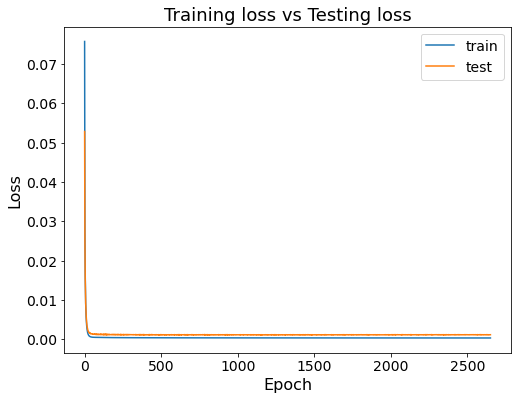

In [36]:
lr = 0.0001
EPOCHS = 6000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


ws_pararcnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1500)
mc = ModelCheckpoint('saved_model/ws_pararcnn_sc4_4layer_{}h.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = ws_pararcnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Performance

In [37]:
# model_load.predict(test_input).shape

In [38]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/ws_pararcnn_sc4_4layer_{}h.h5'.format(K))

In [39]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)


In [40]:
# inv_y

In [41]:
# inv_yhat

In [42]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.1336
RMSE = 0.1644
